In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
dataset = pd.read_csv('../data/coins2.csv')
dataset.head(5)

,size,weight,type
0,2.415939,3.006286,$2
1,2.938768,2.671729,$2
2,1.639263,1.877312,$1
3,1.374895,1.825525,$1
4,2.168431,2.262057,$2


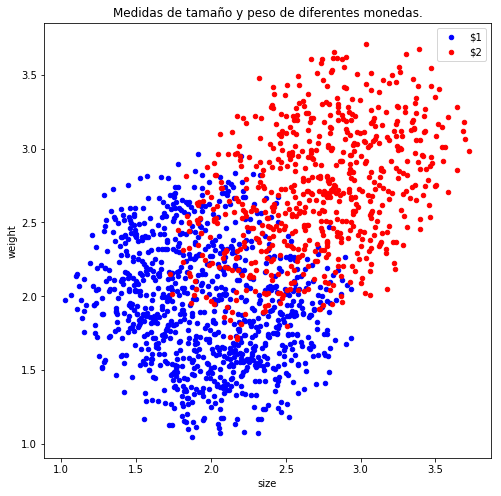

In [6]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax = dataset[dataset.type == '$1'].plot.scatter('size', 'weight', c='blue', ax=ax)
dataset[dataset.type == '$2'].plot.scatter('size', 'weight', c='red', ax=ax)
ax.legend(['$1', '$2'])
ax.set_title('Medidas de tamaño y peso de diferentes monedas.');

# Cree una funcion que dado un dataset evalue la regresión logistica:
$$ h(x) = \frac{1}{1+e^{-s}}, $$
donde
$$ s = \sum_0^d w_i x_i$$

In [20]:
dataset['x0'] = 1
dataset['y'] = dataset.type.apply(lambda x: +1 if x == '$2' else -1)
dataset['rnd'] = np.random.rand(len(dataset))
train = dataset[dataset.rnd < 0.8][['x0', 'size', 'weight', 'y']]
test = dataset[dataset.rnd >= 0.8][['x0', 'size', 'weight', 'y']]

In [22]:
train.head()

,x0,size,weight,y
0,1,2.415939,3.006286,1
2,1,1.639263,1.877312,-1
3,1,1.374895,1.825525,-1
4,1,2.168431,2.262057,1
5,1,2.773153,1.769211,-1


In [37]:
def model(df, w):
    s = df.apply(lambda row: np.dot(w, row[:-1]), axis=1)
    return 1/(1+np.exp(-s))

In [41]:
model(train, np.random.rand(3)).head()

0    0.687353
2    0.627077
3    0.622425
4    0.650169
5    0.630392
dtype: float64

# Cree una funcion que dado un dataset evalue el error:
$$ E_{\mathrm{in}} = \frac{1}{N} \sum_{n=1}^N \ln\left(1 + e^{-y_nw^Tx_n}\right)$$

In [48]:
def cross_entropy(df, w):
    # z = -yWx
    z = - df.apply(lambda row: np.dot(w, row[:-1]), axis=1) * df.y
    return (1/len(df)) * (np.log(1 + np.exp(z))).sum()

In [51]:
cross_entropy(train, np.random.rand(3))

1.2934043683576868

# Cree una funcion que dado un dataset y un conjunto de pesos w, evalue el gradiente del error:
$$\nabla E_{\mathrm{in}} = - \frac{1}{N}\sum_{n=1}^N\frac{y_n x_n}{1 + e^{y_nw^Tx_n}}$$

In [100]:
def gradiente(df, w):
    # z = yWx
    z = df.apply(lambda row: np.dot(w, row[:-1]), axis=1) * df.y
    # v = yx
    v = df.iloc[:,:-1].multiply(df.y, axis=0)
    return - (1/len(df)) * (v.divide(1 + np.exp(z), axis=0)).sum()

In [101]:
gradiente(train, np.random.rand(3))

x0        0.474468
size      0.912746
weight    0.908871
dtype: float64

# Cree una funcion que optimize los pesos w usando el gradiente descendente:

In [133]:
def gradiente_descendente(df, w0, eta=0.002, iterations=1000, error_threshold=0.001):
    w = w0
    error_prev = cross_entropy(df, w)
    for _ in range(iterations):
        grad = gradiente(df, w)
        w -= eta*grad
        error = cross_entropy(df,w)
        if error_prev - error < error_threshold:
            break
        error_prev = error
    return w

In [134]:
w_final = gradiente_descendente(train, np.random.rand(3))
w_final

array([ 0.23481546,  0.19434678,  0.04457623])

In [135]:
cross_entropy(train, w_final)

0.79755626299807214

In [137]:
result = pd.DataFrame({'yhat': model(train, w_final), 'y':train.y})
result.head()

,y,yhat
0,1,0.698119
2,-1,0.654094
3,-1,0.641849
4,1,0.680719
5,-1,0.701119


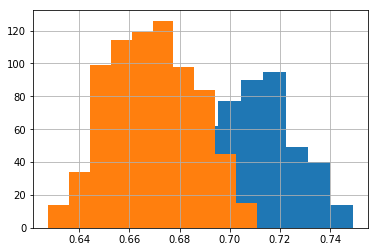

In [139]:
result[result.y == 1].yhat.hist()
result[result.y == -1].yhat.hist()